# How do we sync the recorded audio?

We have audio recordings from each machine. How do we combine them? The audio experienced by each player in the cascade will be different, because the nature of streaming means that there may be changes in latency or dropped chunks. We can't simply put the audio together, or align with a simple offset.

To solve this, we had the lead player generate metronome audio, stream it to others in sequence, and record on each machine. We can use the beat onsets from the metronome recordings to align audio.

The purpose of this notebook is to visualize and demonstrate how that happens.

In [67]:
%matplotlib inline
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa, librosa.display
import numpy as np

In [2]:
plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = None

## The Audio

Let's look at the audio we have to align. The first recording is me clapping eighth notes and counting to 4 along with the metronome. The second recording is my partner trying to clap and count along with the shifting stream. Claps make the visual alignment of peaks easier to see.

/Users/austinblanton1/Dropbox/Documents/code/cascade/notebooks/venv/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/austinblanton1/Dropbox/Documents/code/cascade/notebooks/venv/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


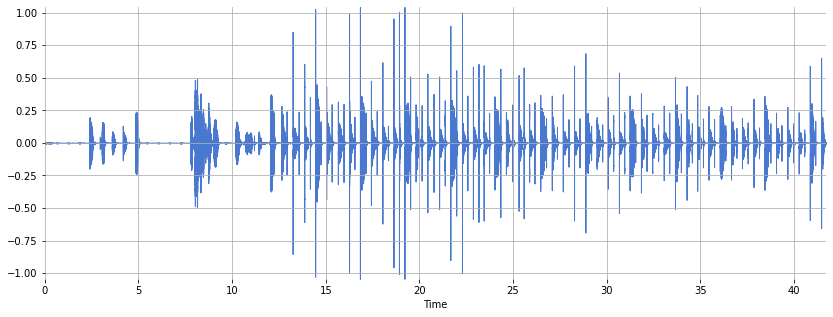

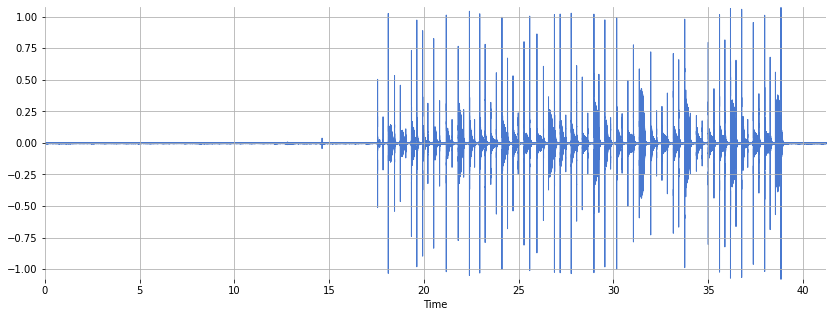

In [51]:
claps = [
    # i grabbed these manually from the video with ffmpeg -acodec copy
    librosa.load('../server/output/cascade0/peer0_audio.opus'),
    librosa.load('../server/output/cascade0/peer1_audio.opus')
]

for x, sr in claps:
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x, sr)

## The Metronome

Let's see what the metronome audio looks like.

/Users/austinblanton1/Dropbox/Documents/code/cascade/notebooks/venv/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/austinblanton1/Dropbox/Documents/code/cascade/notebooks/venv/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


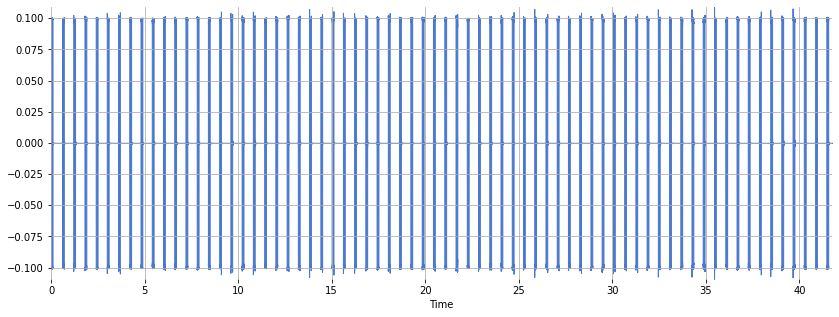

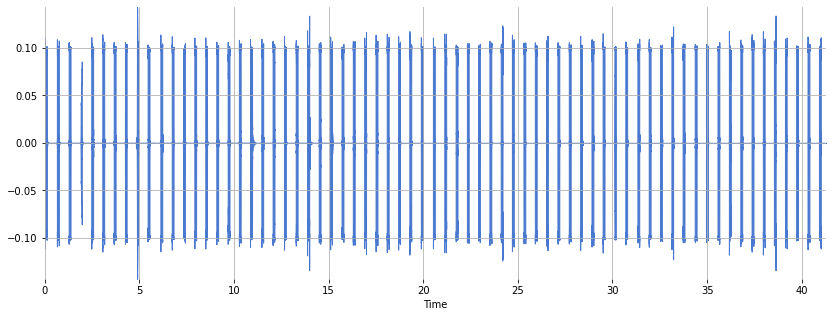

In [41]:
metronomes = [
    librosa.load('../server/output/cascade0/peer0_metronome.webm'),
    librosa.load('../server/output/cascade0/peer1_metronome.webm')
]
for x, sr in metronomes:
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x, sr)

## Onset Detection

We use the `librosa` library to detect the metronome onsets.

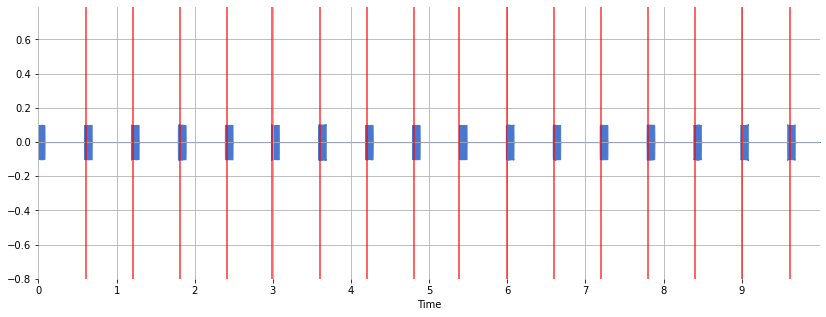

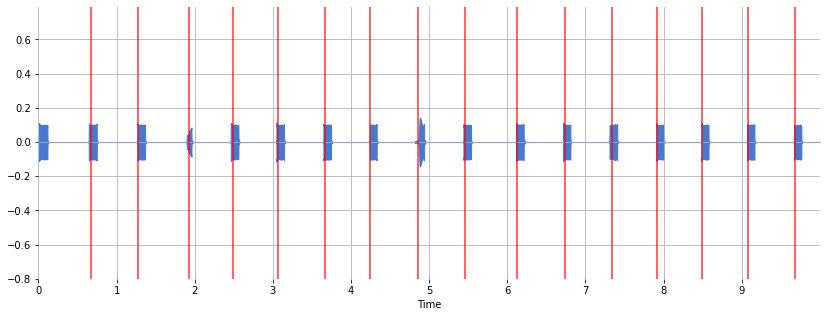

In [50]:
# Copied from the actual code for reference:
def detect_blip_onset(metronome, sample_rate):
    onset_frames = librosa.onset.onset_detect(metronome, sr=sample_rate)
    onset_times = librosa.frames_to_time(onset_frames)
    # onset_times has both on and off times (is an off the onset of silence? 🤔)
    # remove the first marker if it's an off marker
    if (onset_times[1] - onset_times[0]) > 0.2:
        onset_times = onset_times[1:]
    # it has been observed in practice that
    # sometimes the detector will miss the on marker but not the off marker.
    # in this case we'd rather use the off marker than drop a metronome blip.
    is_on_marker = np.insert(
        # if the blip is more than 200ms from the previous marker, call it an onset.
        np.diff(onset_times) > 0.2,
        # and always keep the first marker
        0,
        [True]
    )
    return onset_times[is_on_marker]

# Helper function to display the waveforms with onset markers
def show_waveform_onsets(audio, sample_rate, onset_times):
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(audio, sr=sample_rate)
    plt.vlines(onset_times, -0.8, 0.79, color='r', alpha=0.8)

onsets = [
    detect_blip_onset(metronome, sample_rate)
    for metronome, sample_rate
    in metronomes
]

for onset, (metronome, sample_rate) in zip(onsets, metronomes):
    # zoom in on the first 10 seconds so we can see what's happening
    metro_slice = metronome[:10 * sample_rate]
    show_waveform_onsets(metro_slice, sample_rate, onset)

Let's see the onsets overlaid on the audio.

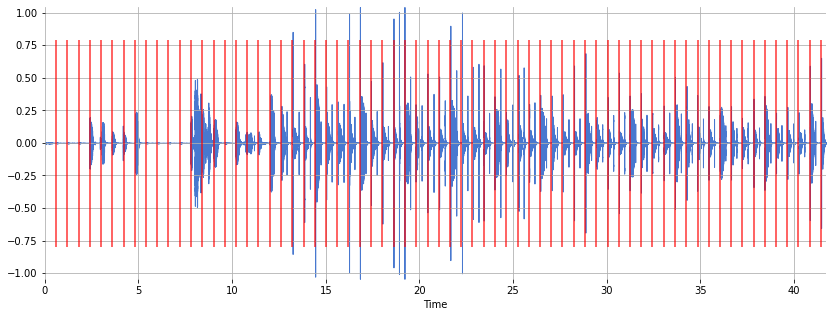

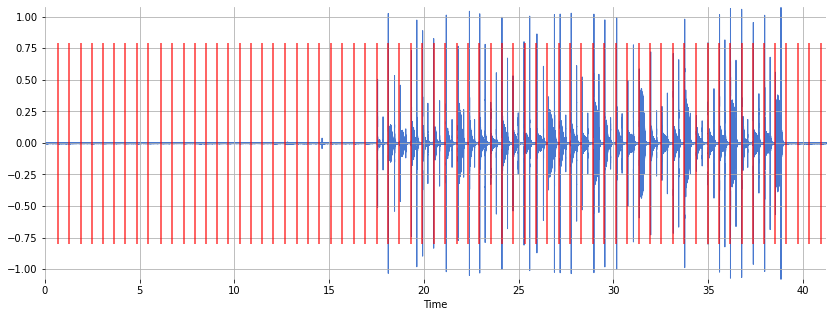

In [52]:
for onset, (clap, sample_rate) in zip(onsets, claps):
    show_waveform_onsets(clap, sample_rate, onset)

Looks like the claps match up roughly with the metronome...Let's zoom in on the second recording to see if it gets out of sync.

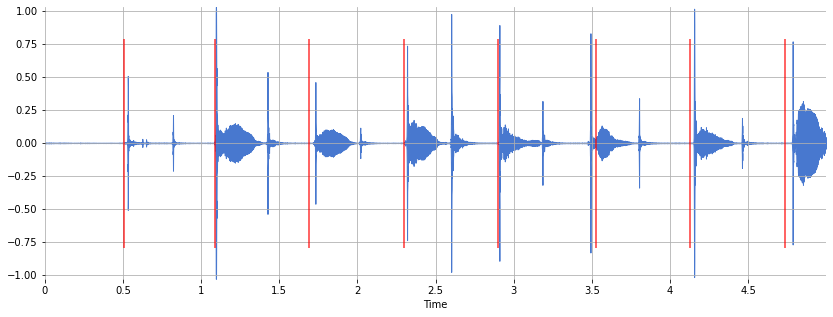

In [59]:
slice_start = 17 # seconds
slice_end = 22
clap, sample_rate = claps[1]
clap_slice = clap[slice_start * sample_rate:slice_end * sample_rate]
onset = onsets[1]
keep_idx = (onset >= slice_start) & (onset < slice_end)
onsets_slice = onset[keep_idx] - slice_start
show_waveform_onsets(clap_slice, sample_rate, onsets_slice)

The clap peaks are close to the metronome onsets. That means that my partner was adjusting to latency changes and clapping along fairly accurately.

Let's overlay the first metronome over the second recording to see how much we need to adjust to match the first recording.

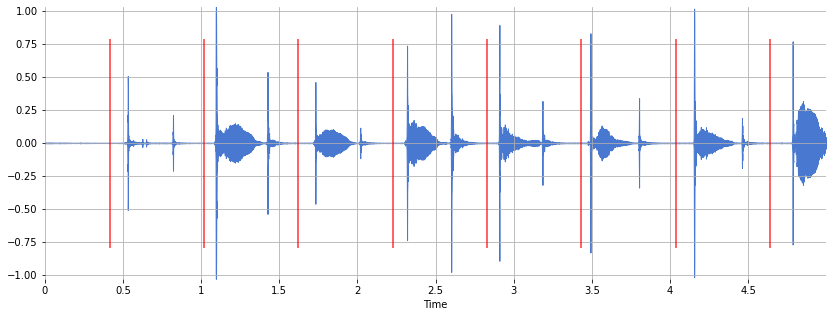

In [64]:
onset = onsets[0]
keep_idx = onset >= slice_start
onsets_slice = onset[keep_idx] - slice_start
show_waveform_onsets(clap_slice, sample_rate, onsets_slice)

## Timeshift

So we want to align the second recording to the first. We do this by slicing the second recording into chunks between metronome onsets, align each chunk at the correct onset time, and stretch the chunk length to fit.

See the `align_videos_to_metronome()` function for details on generating the `ffmpeg` command.

But here is the second recording, aligned and timestretched, overlayed with the first metronome onsets:

/Users/austinblanton1/Dropbox/Documents/code/cascade/notebooks/venv/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


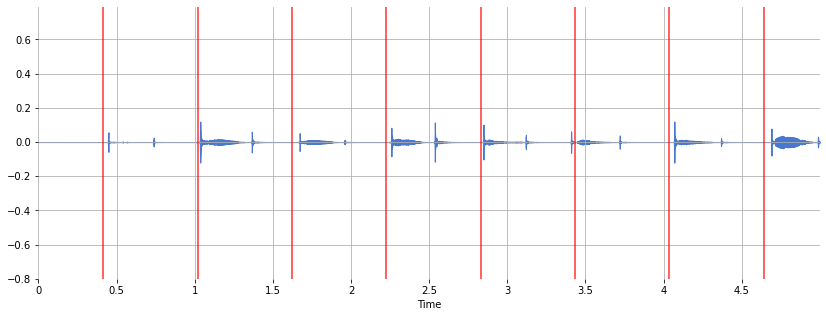

In [62]:
# i modified the ffmpeg command to output just the second recording aligned
claps_aligned, sample_rate = librosa.load('../server/output/cascade0/peer1_aligned.mp3')
claps_aligned_slice = claps_aligned[slice_start * sample_rate:slice_end * sample_rate]
show_waveform_onsets(claps_aligned_slice, sample_rate, onsets_slice)

That looks better, but not perfect...let's see what the fully aligned audio looks like, merging both recordings.

/Users/austinblanton1/Dropbox/Documents/code/cascade/notebooks/venv/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


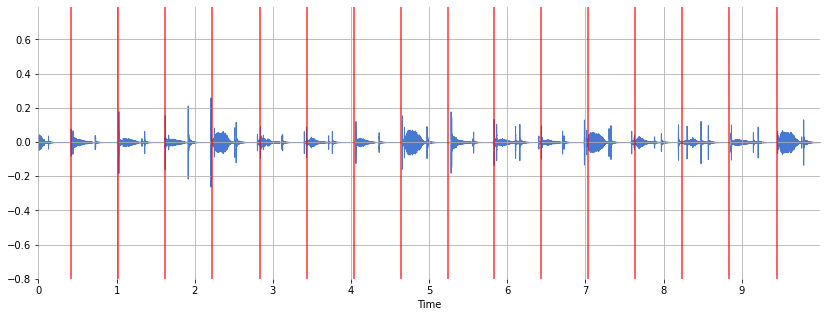

In [68]:
# i also grabbed this audio manually from the video file
slice_end = 27
claps_aligned, sample_rate = librosa.load('../server/output/cascade0/cascade.opus')
claps_aligned_slice = claps_aligned[slice_start * sample_rate:slice_end * sample_rate]
show_waveform_onsets(claps_aligned_slice, sample_rate, onsets_slice)
ipd.Audio(claps_aligned_slice, rate=sample_rate)

You can see double claps where the recordings don't align so well. This method doesn't allow for absolute rhythmic precision, but it's in the ballpark. It's hard to hit a moving target.